# Morgan FP, SMC, A workflow
In this document, we calculated Morgan Fingerprint for each reaction in SMC dataset, and then train them use Random forest, Linear Regression, XGBoost & neural network.

In [254]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
from rdkit.Chem import AllChem, MolFromSmiles
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem import DataStructs
from rdkit import Chem

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

['Cl', 'C', '1', '=', 'C', 'C', '=', 'C', '(', 'O', 'C', ')', 'C', '=', 'C', '1', '.', 'O', 'B', '(', 'O', ')', 'C', '1', '=', 'C', 'C', '=', 'C', 'C', '=', 'C', '1', '>>', 'C', 'O', 'C', '(', 'C', '=', 'C', '1', ')', '=', 'C', 'C', '=', 'C', '1', 'C', '2', '=', 'C', 'C', '=', 'C', 'C', '=', 'C', '2']


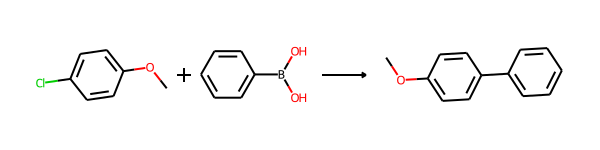

In [255]:
from rxnfp.tokenization import get_default_tokenizer, SmilesTokenizer
from rdkit.Chem import rdChemReactions

smiles_tokenizer = get_default_tokenizer()

reaction_smiles = 'ClC1=CC=C(OC)C=C1.OB(O)C1=CC=CC=C1>>COC(C=C1)=CC=C1C2=CC=CC=C2'
rxn = rdChemReactions.ReactionFromSmarts(reaction_smiles,useSmiles=True)

print(smiles_tokenizer.tokenize(reaction_smiles))
rxn

In [256]:
""""
def canonicalize_with_dict(smi, can_smi_dict={}):
    if smi not in can_smi_dict.keys():
        return Chem.MolToSmiles(Chem.MolFromSmiles(smi))
    else:
        return can_smi_dict[smi]
"""
    
def generate_ligand_data(df):
    #Convert the smiles of ligand to a dataframe.
    df = df.copy()
    
    #ligand_smiles_dict = {}
    rxns = []
    """
    The rxns is not useful now. When we use the whole rxn instead of ligand to predict, it will be convenient.
    To try with the entire rxn, tabulate all chemicals into a single column of dataframe.
    """
    smiles = df['Smiles']
    for i in smiles:
        try:
            ligand_smiles = Chem.MolFromSmiles(i)
            rxns.append(ligand_smiles)
        except:
            print(i)
        
    return rxns
   

# Cleaning up the SMC dataset
Train set: 0-71,  test set: 71-all. Validation set is not applied but easy to add on.

In [257]:
# data
import pandas as pd
from rdkit import Chem
#from rxn_yields.data import generate_buchwald_hartwig_rxns
#df = pd.read_excel('../data/Buchwald-Hartwig/Dreher_and_Doyle_input_data.xlsx', sheet_name='FullCV_01')
df = pd.read_excel('smc_data.xlsx', sheet_name='SMC')
df = df.sample(frac=1,random_state=41)
df['rxn'] = df['Smiles']
df['ligand_data'] = generate_ligand_data(df)
df['Output'] = df['II']

train_df = df.iloc[:71][['rxn', 'Output']] 
valid_df = df.iloc[71:71][['rxn', 'Output']] 
test_df = df.iloc[71:][['rxn', 'Output']] #

train_df.columns = ['text', 'labels']
valid_df.columns = ['text', 'labels']
test_df.columns = ['text', 'labels']
mean = train_df.labels.mean()
std = train_df.labels.std()
train_df['labels'] = (train_df['labels'] - mean) / std
valid_df['labels'] = (valid_df['labels'] - mean) / std
test_df['labels'] = (test_df['labels'] - mean) / std
train_df.head()

,text,labels
81,N#Cc1ccccc1P(c1ccccc1)c1ccccc1,-0.815128
25,COc1ccc(OC)c(c1P(c2cc(cc(c2)C(F)(F)F)C(F)(F)F)...,-0.777178
83,OCP(CO)CO,-0.815128
63,CC(C)(C)P(c1ccccc1-n2nc(cc2-c3ccccc3)-c4ccccc4...,-0.739227
6,CC(C)(C)CP(C(C)(C)C)C(C)(C)C,-0.777178


In [258]:
x=MolFromSmiles("c1ccc(P(C2CCCCC2)C2CCCCC2)cc1")
x = AllChem.GetMorganFingerprintAsBitVect(x,2,nBits=1024)
arr = np.zeros((1,))
DataStructs.ConvertToNumpyArray(x, arr)

x

In [259]:
remover = SaltRemover(defnData="[Cl,Br]")
morgan_list, mol_list_none = [], []
mol_list = []

for i,smiles in enumerate(train_df['text']):
    d1 = MolFromSmiles(smiles)
    if d1 is None:
        mol_list_none.append(i)
    else:
        d2 = remover.StripMol(d1)
        mol_list.append(d2)
        f1 = AllChem.GetMorganFingerprintAsBitVect(d2,2,nBits=1024)
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(f1, arr)
#         print(arr)
        if any(np.isnan(arr)):
            mol_list_none.append(i)
        else:
            morgan_list.append(arr)
            
train_df = train_df.drop(mol_list_none)
train_df["morgan_fingerprints"] = morgan_list
train_df = train_df.reset_index()

train_df.head()

,index,text,labels,morgan_fingerprints
0,81,N#Cc1ccccc1P(c1ccccc1)c1ccccc1,-0.815128,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,25,COc1ccc(OC)c(c1P(c2cc(cc(c2)C(F)(F)F)C(F)(F)F)...,-0.777178,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,83,OCP(CO)CO,-0.815128,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,63,CC(C)(C)P(c1ccccc1-n2nc(cc2-c3ccccc3)-c4ccccc4...,-0.739227,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,6,CC(C)(C)CP(C(C)(C)C)C(C)(C)C,-0.777178,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [260]:
remover = SaltRemover(defnData="[Cl,Br]")
morgan_list, mol_list_none = [], []
mol_list = []

for i,smiles in enumerate(valid_df['text']):
    d1 = MolFromSmiles(smiles)
    if d1 is None:
        mol_list_none.append(i)
    else:
        d2 = remover.StripMol(d1)
        mol_list.append(d2)
        f1 = AllChem.GetMorganFingerprintAsBitVect(d2,2,nBits=1024)
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(f1, arr)
#         print(arr)
        if any(np.isnan(arr)):
            mol_list_none.append(i)
        else:
            morgan_list.append(arr)
            
valid_df = valid_df.drop(mol_list_none)
valid_df["morgan_fingerprints"] = morgan_list
valid_df = valid_df.reset_index()

valid_df.head()

,index,text,labels,morgan_fingerprints


In [261]:
remover = SaltRemover(defnData="[Cl,Br]")
morgan_list, mol_list_none = [], []
mol_list = []

for i,smiles in enumerate(test_df['text']):
    d1 = MolFromSmiles(smiles)
    if d1 is None:
        mol_list_none.append(i)
    else:
        d2 = remover.StripMol(d1)
        mol_list.append(d2)
        f1 = AllChem.GetMorganFingerprintAsBitVect(d2,2,nBits=1024)
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(f1, arr)
#         print(arr)
        if any(np.isnan(arr)):
            mol_list_none.append(i)
        else:
            morgan_list.append(arr)
            
test_df = test_df.drop(mol_list_none)
test_df["morgan_fingerprints"] = morgan_list
test_df = test_df.reset_index()

test_df.head()

,index,text,labels,morgan_fingerprints
0,28,N#CCCP(CCC#N)CCC#N,-0.815128,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,17,c1ccc(P(C2CCCCC2)C2CCCCC2)cc1,0.778781,"[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
2,55,CC(C)CP(CC(C)C)CC(C)C,1.044433,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,52,C1N2CN3CN1CP(C2)C3,-0.815128,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,75,C1[C@@H]2C[C@@H]3C[C@H]1C[C@](C2)(C3)P(c4ccnn4...,-0.739227,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [262]:
X_train = train_df['morgan_fingerprints'].tolist()
y_train = train_df['labels'].tolist()

X_valid = valid_df['morgan_fingerprints'].tolist()
y_valid = valid_df['labels'].tolist()

X_test = test_df['morgan_fingerprints'].tolist()
y_test = test_df['labels'].tolist()

df_entire_x  = X_train + X_test
df_entire_y = y_train + y_test


In [263]:
print(y_train[0], type(y_train[0]))

-0.8151279170082893 <class 'float'>


# Decision Tree Model

In [264]:
from sklearn.tree import DecisionTreeClassifier
Dt_clf = DecisionTreeClassifier(criterion = 'entropy')
y_train_dt = pd.cut(train_df.labels,bins=[-1,-0.5,0,0.5,1,5],labels=['Very Low','Low','Mediium','High','Very High'])
y_test_dt = pd.cut(test_df.labels,bins=[-1,-0.5,0,0.5,1,5],labels=['Very Low','Low','Mediium','High','Very High'])

Dt_clf.fit(X_train, y_train_dt)

DecisionTreeClassifier(criterion='entropy')

In [265]:
from sklearn.metrics import accuracy_score
print('Accuracy Score on train data: ', accuracy_score(y_true=y_train_dt, y_pred=Dt_clf.predict(X_train)))
print('Accuracy Score on test data: ', accuracy_score(y_true=y_test_dt, y_pred=Dt_clf.predict(X_test)))

Accuracy Score on train data:  1.0
Accuracy Score on test data:  0.5263157894736842


In [266]:
from sklearn.tree import DecisionTreeRegressor
Dt_reg = DecisionTreeRegressor(max_depth = 6)
Dt_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=6)

In [267]:
Dt_reg_predictions = Dt_reg.predict(X_train)
Dt_reg_mse = mean_squared_error(y_train, Dt_reg_predictions)
Dt_reg_rmse = np.sqrt(Dt_reg_mse)
print("Training set RMSE:",Dt_reg_rmse)

Dt_reg_predictions2 = Dt_reg.predict(X_test)
Dt_reg_mse2 = mean_squared_error(y_test, Dt_reg_predictions2)
Dt_reg_rmse2 = np.sqrt(Dt_reg_mse2)
print("Test set RMSE:",Dt_reg_rmse2)

Training set RMSE: 0.4825493668066398
Test set RMSE: 0.7332420399287621


In [268]:
r2_score2=r2_score(y_train, Dt_reg_predictions)
print("Training set R^2:",r2_score2)
r2_score3=r2_score(y_test, Dt_reg_predictions2)
print("Test set R^2:",r2_score3)

Training set R^2: 0.7638196244315754
Test set R^2: -0.026084134254301006


In [269]:
cvd_scores = cross_val_score(Dt_reg, df_entire_x, df_entire_y,cv=5)
print('Cross Validation Score:',cvd_scores)

Cross Validation Score: [-2.10544528 -0.11848367 -0.23292553  0.05821159 -0.05766298]


# Random Forest Model

In [270]:
from sklearn.ensemble import RandomForestRegressor

RF_clf = RandomForestRegressor(max_features=0.8,min_impurity_decrease=0,min_samples_leaf=1,n_estimators=500)
RF_clf.fit(X_train, y_train)

RandomForestRegressor(max_features=0.8, min_impurity_decrease=0,
                      n_estimators=500)

In [271]:
forest_predictions = RF_clf.predict(X_train)
forest_mse = mean_squared_error(y_train, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
print("Training set RMSE:",forest_rmse)

forest_predictions2 = RF_clf.predict(X_test)
forest_mse2 = mean_squared_error(y_test, forest_predictions2)
forest_rmse2 = np.sqrt(forest_mse2)
print("Test set RMSE:",forest_rmse2)


Training set RMSE: 0.3461060339788231
Test set RMSE: 0.5480489380102775


In [272]:
r2_score2=r2_score(y_train, forest_predictions)
print("Training set R^2:",r2_score2)
r2_score3=r2_score(y_test, forest_predictions2)
print("Test set R^2:",r2_score3)

Training set R^2: 0.8784993362897847
Test set R^2: 0.4267726023539259


In [273]:
cvd_scores = cross_val_score(RF_clf, df_entire_x, df_entire_y, cv=5)
print('Cross Validation Score:',cvd_scores)

Cross Validation Score: [-1.41463565 -0.01967486  0.41891495 -0.03590628  0.35762552]


# Linear Regression

In [274]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)

In [275]:
reg_predictions = reg.predict(X_train)
reg_mse = mean_squared_error(y_train, reg_predictions)
reg_rmse = np.sqrt(reg_mse)
print("Training set RMSE:",reg_rmse)

reg_predictions2 = reg.predict(X_test)
reg_mse2 = mean_squared_error(y_test, reg_predictions2)
reg_rmse2 = np.sqrt(reg_mse2)
print("Test set RMSE:",reg_rmse2)


regr2_score2=r2_score(y_train, reg_predictions)
print("Training set R^2:",regr2_score2)
regr2_score3=r2_score(y_test, reg_predictions2)
print("Test set R^2:",regr2_score3)

Training set RMSE: 0.20215136986223642
Test set RMSE: 6270889543737.121
Training set R^2: 0.958551035429433
Test set R^2: -7.504928528694237e+25


In [276]:
cvd_scores = cross_val_score(reg, df_entire_x, df_entire_y, cv=5)
print('Cross Validation Score:',cvd_scores)

Cross Validation Score: [-4.73097578e+26 -1.24777050e+24 -3.68662905e+22 -1.31943119e+26
 -1.63268700e+26]


# XG Boost

In [277]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.200000012,
             max_delta_step=0, max_depth=3, min_child_weight=1, 
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=4, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)
xgb_model.fit(X_train, y_train)

[21:15:26] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.200000012,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=4, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [278]:
xgb_predictions = xgb_model.predict(X_train)
xgb_mse = mean_squared_error(y_train, xgb_predictions)
xgb_rmse = np.sqrt(xgb_mse)
print("Training set RMSE:",xgb_rmse)

xgb_predictions2 = xgb_model.predict(X_test)
xgb_mse2 = mean_squared_error(y_test, xgb_predictions2)
xgb_rmse2 = np.sqrt(xgb_mse2)
print("Test set RMSE:",xgb_rmse2)


xgbr2_score2=r2_score(y_train, xgb_predictions)
print("Training set R^2:",xgbr2_score2)
xgbr2_score3=r2_score(y_test, xgb_predictions2)
print("Test set R^2:",xgbr2_score3)

Training set RMSE: 0.13056624712991313
Test set RMSE: 0.42224819442177164
Training set R^2: 0.9827089187548449
Test set R^2: 0.659729843547362


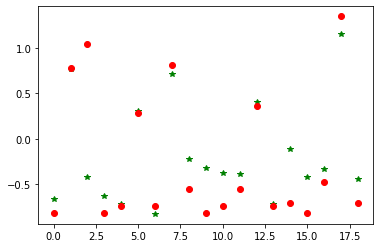

In [309]:
import matplotlib.pyplot as plt
plt.plot(xgb_predictions2,'g*', y_test, 'ro')
plt.show()

In [279]:
cvd_scores = cross_val_score(xgb_model, df_entire_x, df_entire_y, cv=5)
print('Cross Validation Score:',cvd_scores)

[21:15:26] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:26] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:26] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:26] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[21:15:26] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
Cross Validation Score: [-2.02

# Cross Validation

In [330]:
def evaluate_model_of_n_features(train_x,train_y,test_x,test_y,model):
    predictions = model.predict(train_x)
    mse = mean_squared_error(train_y, predictions)
    rmse = np.sqrt(mse)

    predictions2 = model.predict(test_x)
    mse2 = mean_squared_error(test_y, predictions2)
    rmse2 = np.sqrt(mse2)


    score2=r2_score(train_y, predictions)
    score3=r2_score(test_y, predictions2)
    plt.plot(predictions2,'g*', test_y, 'ro')
    plt.show()
    return rmse, rmse2, score2, score3

In [331]:
def fold_5_cross_validation_for_stream(df_x,df_y,model):
    train_x = df_x[:(int((len(df_x)*0.79)))]
    train_y = df_y[:(int((len(df_x)*0.79)))]
    test_x = df_x[(int((len(df_x)*0.79))):]
    test_y = df_y[(int((len(df_x)*0.79))):]
    model.fit(train_x, train_y)
    #print('Intercept:',Intercept,', Coefficient: ',Coefficients)
    train_rmse, test_rmse, train_r2,test_r2 = evaluate_model_of_n_features(train_x,train_y,test_x,test_y,model)
    #print('Training set RMSE:',train_rmse, '\nTest set RMSE: ',test_rmse, '\nTraining set R^2:',train_r2, '\nTest set R^2: ',test_r2 )
    cvd_scores = cross_val_score(model, df_x, df_y, cv=5)
    sum_cvd = sum(cvd_scores)
    print('5 fold Cross Validation score: ',sum_cvd)
    return sum_cvd

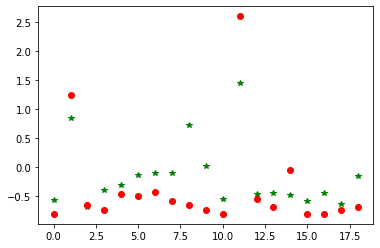

5 fold Cross Validation score:  -0.07176478442227074


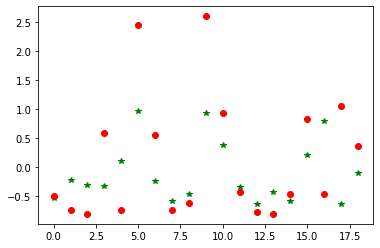

5 fold Cross Validation score:  0.6874794831762755


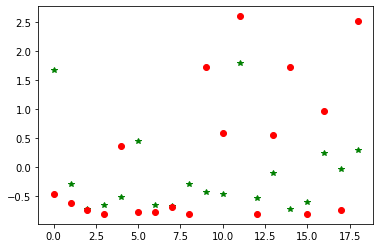

5 fold Cross Validation score:  -0.7841036554338509


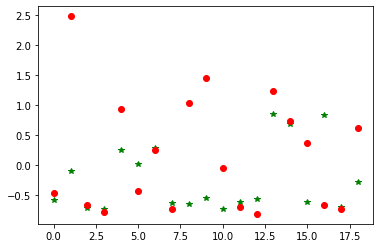

5 fold Cross Validation score:  0.6534398591605031


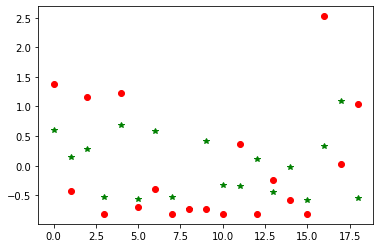

5 fold Cross Validation score:  0.8542091725767327


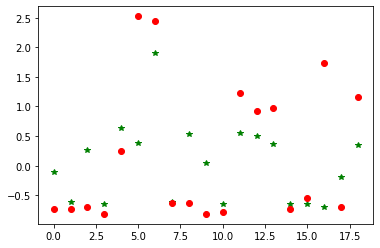

5 fold Cross Validation score:  0.44154190881099586


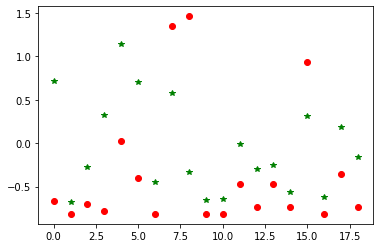

5 fold Cross Validation score:  0.8584479639973809


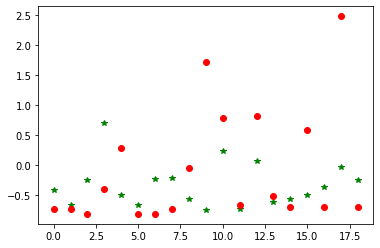

5 fold Cross Validation score:  -0.4752479785118413


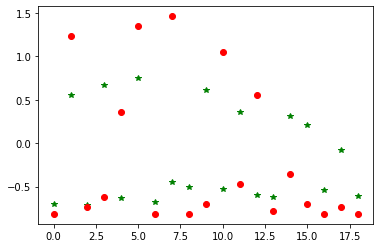

5 fold Cross Validation score:  -0.8726560796422115


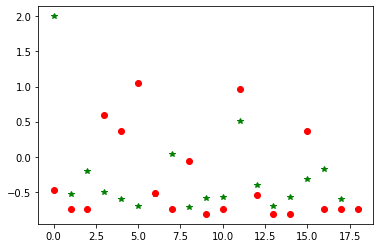

5 fold Cross Validation score:  0.5479900308604997


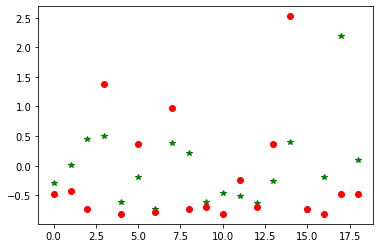

5 fold Cross Validation score:  0.6464008165331109


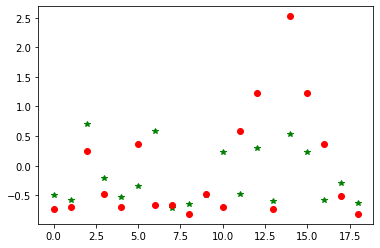

5 fold Cross Validation score:  0.41872622854345254


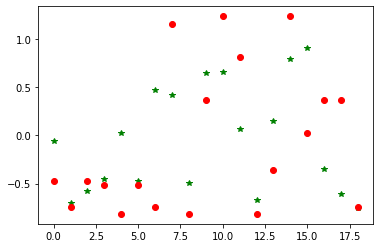

5 fold Cross Validation score:  0.7619239958699128


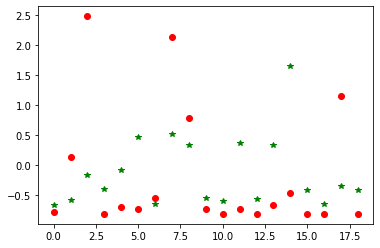

5 fold Cross Validation score:  0.9687436800898772


In [337]:
import random

comb1=0
comb2=0
comb3=0
iter = 15

for i in range(1,iter):

    random.Random(i).shuffle(df_entire_x)
    random.Random(i).shuffle(df_entire_y)
    #print('x',df_entire_x,'y',df_entire_y)
    #comb1 += fold_5_cross_validation_for_stream(df_entire_x,df_entire_y,xgb_model)
    #comb2 += fold_5_cross_validation_for_stream(df_entire_x,df_entire_y,Dt_reg)
    
    comb3 += fold_5_cross_validation_for_stream(df_entire_x,df_entire_y,RF_clf)
comb1_avg= comb1/iter/5
comb2_avg= comb2/iter/5
comb3_avg= comb3/iter/5



In [339]:
print(comb1,comb2,comb3_avg)

0 0 0.061801741888114214


# NN model

Re-splitting the data: Train set: 0-71, validation set: 71-81, test set: 81-all

In [284]:
# data
import pandas as pd
from rdkit import Chem
#from rxn_yields.data import generate_buchwald_hartwig_rxns
#df = pd.read_excel('../data/Buchwald-Hartwig/Dreher_and_Doyle_input_data.xlsx', sheet_name='FullCV_01')
df = pd.read_excel('smc_data.xlsx', sheet_name='SMC')
df = df.sample(frac=1,random_state=42)
df['rxn'] = df['Smiles']
df['ligand_data'] = generate_ligand_data(df)
df['Output'] = df['II']

train_df = df.iloc[:71][['rxn', 'Output']] 
valid_df = df.iloc[71:81][['rxn', 'Output']] 
test_df = df.iloc[81:][['rxn', 'Output']] #

train_df.columns = ['text', 'labels']
valid_df.columns = ['text', 'labels']
test_df.columns = ['text', 'labels']
mean = train_df.labels.mean()
std = train_df.labels.std()
train_df['labels'] = (train_df['labels'] - mean) / std
valid_df['labels'] = (valid_df['labels'] - mean) / std
test_df['labels'] = (test_df['labels'] - mean) / std
train_df.head()

,text,labels
40,CC(C)(C)c1cc(C(C)(C)C)c(-c2cc(-c3c(C(C)(C)C)cc...,-0.402648
22,COc1ccc(OC)c(c1P(C(C)(C)C)C(C)(C)C)-c2c(cc(cc2...,-0.483291
55,CC(C)CP(CC(C)C)CC(C)C,1.129572
70,C1CCC(CC1)P(C2CCCCC2)c3cc4ccccc4n3-c5ccccc5,0.887642
0,CN(C)C(C=CC=C1N(C)C)=C1C2=CC=CC=C2P(C3CCCCC3)C...,-0.725220


In [285]:
remover = SaltRemover(defnData="[Cl,Br]")
morgan_list, mol_list_none = [], []
mol_list = []

for i,smiles in enumerate(train_df['text']):
    d1 = MolFromSmiles(smiles)
    if d1 is None:
        mol_list_none.append(i)
    else:
        d2 = remover.StripMol(d1)
        mol_list.append(d2)
        f1 = AllChem.GetMorganFingerprintAsBitVect(d2,2,nBits=1024)
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(f1, arr)
#         print(arr)
        if any(np.isnan(arr)):
            mol_list_none.append(i)
        else:
            morgan_list.append(arr)
            
train_df = train_df.drop(mol_list_none)
train_df["morgan_fingerprints"] = morgan_list
train_df = train_df.reset_index()

train_df.head()

,index,text,labels,morgan_fingerprints
0,40,CC(C)(C)c1cc(C(C)(C)C)c(-c2cc(-c3c(C(C)(C)C)cc...,-0.402648,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
1,22,COc1ccc(OC)c(c1P(C(C)(C)C)C(C)(C)C)-c2c(cc(cc2...,-0.483291,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,55,CC(C)CP(CC(C)C)CC(C)C,1.129572,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,70,C1CCC(CC1)P(C2CCCCC2)c3cc4ccccc4n3-c5ccccc5,0.887642,"[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0,CN(C)C(C=CC=C1N(C)C)=C1C2=CC=CC=C2P(C3CCCCC3)C...,-0.725220,"[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."


In [286]:
remover = SaltRemover(defnData="[Cl,Br]")
morgan_list, mol_list_none = [], []
mol_list = []

for i,smiles in enumerate(valid_df['text']):
    d1 = MolFromSmiles(smiles)
    if d1 is None:
        mol_list_none.append(i)
    else:
        d2 = remover.StripMol(d1)
        mol_list.append(d2)
        f1 = AllChem.GetMorganFingerprintAsBitVect(d2,2,nBits=1024)
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(f1, arr)
#         print(arr)
        if any(np.isnan(arr)):
            mol_list_none.append(i)
        else:
            morgan_list.append(arr)
            
valid_df = valid_df.drop(mol_list_none)
valid_df["morgan_fingerprints"] = morgan_list
valid_df = valid_df.reset_index()

valid_df.head()

,index,text,labels,morgan_fingerprints
0,85,O=C(O)c1cccc(P(c2cccc(C(=O)O)c2)c2cccc(C(F)(F)...,-0.846185,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,59,Cc1ccccc1-c2ccccc2P(C3CCCCC3)C4CCCCC4,-0.483291,"[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
2,63,CC(C)(C)P(c1ccccc1-n2nc(cc2-c3ccccc3)-c4ccccc4...,-0.765542,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,77,FC(F)(F)C(F)(F)C(F)(F)C(Cc1ccc(P(c2ccccc2)c2cc...,-0.523612,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,37,CC(C)(C)c1cc(P(CC2CCCC2)c2cc(C(C)(C)C)cc(C(C)(...,0.403783,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."


In [287]:
remover = SaltRemover(defnData="[Cl,Br]")
morgan_list, mol_list_none = [], []
mol_list = []

for i,smiles in enumerate(test_df['text']):
    d1 = MolFromSmiles(smiles)
    if d1 is None:
        mol_list_none.append(i)
    else:
        d2 = remover.StripMol(d1)
        mol_list.append(d2)
        f1 = AllChem.GetMorganFingerprintAsBitVect(d2,2,nBits=1024)
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(f1, arr)
#         print(arr)
        if any(np.isnan(arr)):
            mol_list_none.append(i)
        else:
            morgan_list.append(arr)
            
test_df = test_df.drop(mol_list_none)
test_df["morgan_fingerprints"] = morgan_list
test_df = test_df.reset_index()

test_df.head()

,index,text,labels,morgan_fingerprints
0,23,CC(C)c1cc(C(C)C)c(c(c1)C(C)C)-c2ccccc2P(C(C)(C...,-0.765542,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,83,OCP(CO)CO,-0.846185,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,74,c1ccc(P(C2CCCCC2)C2CCCCC2)c(-n2c3ccccc3c3ccccc...,-0.604255,"[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,82,COC(=O)CCP(CCC(=O)OC)CCC(=O)OC,-0.846185,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,20,Cc1cccc(P(c2cccc(C)c2)c2cccc(C)c2)c1,1.573109,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [288]:
import torch.nn.functional as F
import torch.nn as nn
import torch
class Model(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size=1024, hidden_size=2048, out_size=1, n_hidden=0, activation=F.relu, bn=False,
                **kwargs):
        super().__init__()
        self.bn = bn
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.hiddens = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(n_hidden)])
        self.bn_hiddens = nn.ModuleList([nn.BatchNorm1d(hidden_size) for i in range(n_hidden)])
        self.bn = nn.BatchNorm1d(hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        self.activation = activation
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        for l, bn in zip(self.hiddens, self.bn_hiddens):
            if self.bn:
                out = bn(out)
            out = self.activation(out)
            out = l(out)
        # Apply activation function
        if self.bn:
            out = self.bn(out)
        out = self.activation(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out.view(-1)   
    
    def training_step(self, batch):
        images, labels = batch 
        #print(images.dtype, labels.dtype)
        out = self(images).view(-1)  
        #print(out.dtype)# Generate predictions
        loss = F.mse_loss(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images).view(-1)                       # Generate predictions
        loss = F.mse_loss(out, labels)   # Calculate loss           # Calculate accuracy
        return {'val_loss': loss}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
#         batch_accs = [x['val_acc'] for x in outputs]
#         epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['train_loss'], result['val_loss']))

In [289]:
default_nn = Model()

In [290]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

device(type='cuda')

In [291]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [292]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

x_train, y_train, X_valid, y_valid, x_test, y_test = map(
    torch.tensor, (X_train, y_train, X_valid, y_valid, X_test, y_test)
)


training_data = TensorDataset(x_train.to(torch.float32), y_train)
validation_data = TensorDataset(X_valid.to(torch.float32), y_valid)
test_data = TensorDataset(x_test.to(torch.float32), y_test)

batch_size = 128

# Create data loaders.
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(validation_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_loader:
    print("Shape of X [N, C]: ", X.shape,X.dtype)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C]:  torch.Size([19, 1024]) torch.float32
Shape of y:  torch.Size([19]) torch.float32


In [293]:
train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)

In [294]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [295]:
for X, y in train_loader:
    print("Shape of X [N, C]: ", X.shape,X.dtype)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C]:  torch.Size([71, 1024]) torch.float32
Shape of y:  torch.Size([71]) torch.float32


In [296]:
import copy
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=5)
    best_loss = np.inf
    best_model = None
    for epoch in range(epochs):
        # Training Phase 
        train_loss = 0.
        train_count = 0
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()*len(batch)
            train_count += len(batch)
        train_loss /= train_count
        # Validation phase
        result = evaluate(model, val_loader)
        result["train_loss"] = train_loss
        scheduler.step(result["val_loss"])
        
        if result["val_loss"] < best_loss:
            best_model = copy.deepcopy(model)
        
        if epoch%20 == 0:
            model.epoch_end(epoch, result)
        history.append(result)
    return history, best_model

In [297]:
default_nn = default_nn

In [298]:
default_nn = Model().to(device)
history, best_model = fit(150, 0.0005, default_nn, train_loader, valid_loader)

RuntimeError: stack expects a non-empty TensorList

In [ ]:
from sklearn.metrics import mean_squared_error
print("train RMSE: ", mean_squared_error(y_train.cpu(), best_model(to_device(x_train.to(torch.float32), device)).cpu().detach().numpy()))
print("test RMSE: ", mean_squared_error(y_test.cpu(), best_model(to_device(x_test.to(torch.float32), device)).cpu().detach().numpy()))

train RMSE:  0.45170158
test RMSE:  0.9504912


In [ ]:
from sklearn.metrics import r2_score
r2_score5=r2_score(y_train.cpu(), best_model(to_device(x_train.to(torch.float32), device)).cpu().detach().numpy())
print("Training set R^2:",r2_score5)
r2_score6=r2_score(y_test.cpu(), best_model(to_device(x_test.to(torch.float32), device)).cpu().detach().numpy())
print("test set R^2:",r2_score6)

Training set R^2: 0.5418456009875364
test set R^2: -228.75757786934545


In [ ]:
def train_curve(history):
    for key in ["train_loss", "val_loss"]:
        plt.plot([history_[key] for history_ in history], label=key)
    plt.xlabel("epoch")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()

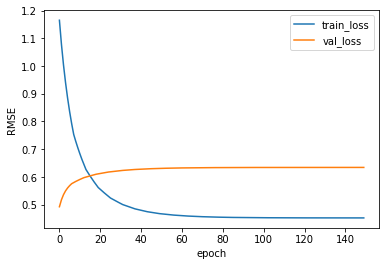

In [ ]:
train_curve(history)

# Summary
#### Random Forest:
Training set RMSE: 0.0979

Test set RMSE: 0.269

Training set R^2: 0.990

Test set R^2: 0.930


#### Neural Network:
Training set RMSE: 0.0895

Test set RMSE: 0.136

Training set R^2: 0.911

Test set R^2: 0.868